# Analyze NFT in Indonesia using Twitter (Tweepy)

I want to know about NFT in Indonesia, since Ghozali Everyday's NFT exploded into a Viral, and E-KTP was uploaded on openSea to be traded. The aim is to find out the interest of the Indonesian people regarding NFT through Twitter.

In [1]:
# Importing the Library & Package

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, tweepy, re, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import gensim.models.ldamodel
from pprint import pprint
import tqdm
import pyLDAvis
import pyLDAvis.gensim_models

Importing libraries and packages that will be used in this project

In [2]:
# Opening token for access the twitter API, I'm using API V1.1 token

with open("token_sanber.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

Enter the token on the twitter developer account, I use the token from twitter developer web to access API V1.1. Create the token into data .json and save it in the same directory as this file

## Data Collection

In [3]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

search_words = "nft di indonesia"
new_search = search_words + " -filter:retweets"

tweets = tweepy.Cursor(api.search_tweets,
        q=new_search,
        lang="id").items(300)

Started accessing the Twitter API, by searching for tweets about 'nft in indonesia' ignoring retweets. Look for tweets up to 300 (so as not to hit the limit). Why am I not looking for data between the certain date? Because the account I use to access the Twitter API is not premium, so if I enter date range, it will return 0 tweets. Here I quote from the twitter documentation for the standard search API:

'Before digging in, it’s important to know that the standard search API is focused on relevance and not completeness. This means that some Tweets and users may be missing from search results. If you want to match for completeness you should consider the premium or enterprise search APIs.'

In [4]:
items = []
for tweet in tweets:
    items.append(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.text).split()))
df = pd.DataFrame(data=items, columns=['tweet'])
df

Extract those tweets into 'items' by eliminating unused chars. After that, save the data into the 'df' dataframe

## Data Preparation

In [7]:
def case_folding(data):
    data = data.lower()
    data = ' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("", "", string.punctuation))
    data = re.sub(r"\n", "", data)
    return data

def tokenizing(data):
    data = word_tokenize(data)
    return data

def slang_cleaner(data, slang_list:list=[]):
    word_token = tokenizing(data)
    word_list = []

    for word in word_token:
        for slang in slang_list:
            if word.lower() in slang[0].lower():
                word = slang[1]
                break
        word_list.append(word)
    data = ' '.join(word_list)
    return data

def clear_stopwords(data):
    indonesia_s = stopwords.words('indonesian')
    data = [word for word in data if word not in indonesia_s]
    data = ' '.join(data)
    return data

There are 'case_folding', 'tokenizing', 'slang_cleaner', and 'clear_stopwords'. Each function is to clean data from typos, separate sentences into words, slang words, unused chars, and eliminate if the data is not in Indonesian.

In [8]:
df['clean_tweet'] = df['tweet'].apply(lambda x: case_folding(x))
df

,tweet,clean_tweet
0,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil membuat nft dikenal masyaraka...
1,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil membuat nf...
2,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil membuat nft dikenal masyaraka...
3,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil membuat nft dikenal masyaraka...
4,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil membuat nf...
...,...,...
295,Ghozali Ghozalu sudah menjual sebanyak 933 NFT...,ghozali ghozalu sudah menjual sebanyak nft de...
296,Inisiator Kedaulatan Digital Republik Indonesi...,inisiator kedaulatan digital republik indonesi...
297,Cerita Adrian dibalik kesuksesan Ghozali menda...,cerita adrian dibalik kesuksesan ghozali menda...
298,fenomena NFT di Indonesia pun mulai meningkat ...,fenomena nft di indonesia pun mulai meningkat ...


The first one, I did case folding, which was to reduce all sentences (lowercase), delete chars that are side by side with numbers, for example 'iya2', remove \n or enter.

In [9]:
slang_list = [
    ('gak','tidak'),
    ('kalo', ' '),
    ('jni', ' '),
    ('hehe', ' '),
    ('hehee', ' '),
    ('yg', 'yang'),
    ('tp', ' '),
    ('aja', 'saja'),
    ('cobq', 'coba'),
    ('menj', ' '),
]

df['clean_tweet'] = df['clean_tweet'].apply(lambda x : slang_cleaner(x, slang_list))
df

,tweet,clean_tweet
0,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil membuat nft dikenal masyaraka...
1,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil membuat nf...
2,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil membuat nft dikenal masyaraka...
3,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil membuat nft dikenal masyaraka...
4,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil membuat nf...
...,...,...
295,Ghozali Ghozalu sudah menjual sebanyak 933 NFT...,ghozali ghozalu sudah menjual sebanyak nft den...
296,Inisiator Kedaulatan Digital Republik Indonesi...,inisiator kedaulatan digital republik indonesi...
297,Cerita Adrian dibalik kesuksesan Ghozali menda...,cerita adrian dibalik kesuksesan ghozali menda...
298,fenomena NFT di Indonesia pun mulai meningkat ...,fenomena nft di indonesia pun mulai meningkat ...


Deleting Indonesian slang words, after separating them into words, then checking the words one by one, and eliminating words that are included in the 'slang_list'.

In [10]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: tokenizing(x))
df

,tweet,clean_tweet
0,Ghozali berhasil membuat NFT dikenal masyaraka...,"[ghozali, berhasil, membuat, nft, dikenal, mas..."
1,LordGhozaliKuyouID Ghozali berhasil membuat NF...,"[lordghozalikuyouid, ghozali, berhasil, membua..."
2,Ghozali berhasil membuat NFT dikenal masyaraka...,"[ghozali, berhasil, membuat, nft, dikenal, mas..."
3,Ghozali berhasil membuat NFT dikenal masyaraka...,"[ghozali, berhasil, membuat, nft, dikenal, mas..."
4,LordGhozaliKuyouID Ghozali berhasil membuat NF...,"[lordghozalikuyouid, ghozali, berhasil, membua..."
...,...,...
295,Ghozali Ghozalu sudah menjual sebanyak 933 NFT...,"[ghozali, ghozalu, sudah, menjual, sebanyak, n..."
296,Inisiator Kedaulatan Digital Republik Indonesi...,"[inisiator, kedaulatan, digital, republik, ind..."
297,Cerita Adrian dibalik kesuksesan Ghozali menda...,"[cerita, adrian, dibalik, kesuksesan, ghozali,..."
298,fenomena NFT di Indonesia pun mulai meningkat ...,"[fenomena, nft, di, indonesia, pun, mulai, men..."


Then separate it into words, to be processed to remove stopwords in Indonesian.

In [11]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: clear_stopwords(x))
df

,tweet,clean_tweet
0,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...
1,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil nft dikena...
2,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...
3,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...
4,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil nft dikena...
...,...,...
295,Ghozali Ghozalu sudah menjual sebanyak 933 NFT...,ghozali ghozalu menjual nft harga eth rp ribu ...
296,Inisiator Kedaulatan Digital Republik Indonesi...,inisiator kedaulatan digital republik indonesi...
297,Cerita Adrian dibalik kesuksesan Ghozali menda...,cerita adrian dibalik kesuksesan ghozali uang ...
298,fenomena NFT di Indonesia pun mulai meningkat ...,fenomena nft indonesia meningkat masyarakat pe...


To eliminate stopwords in Indonesian, which are common words that usually appear in large numbers, but have no meaning.

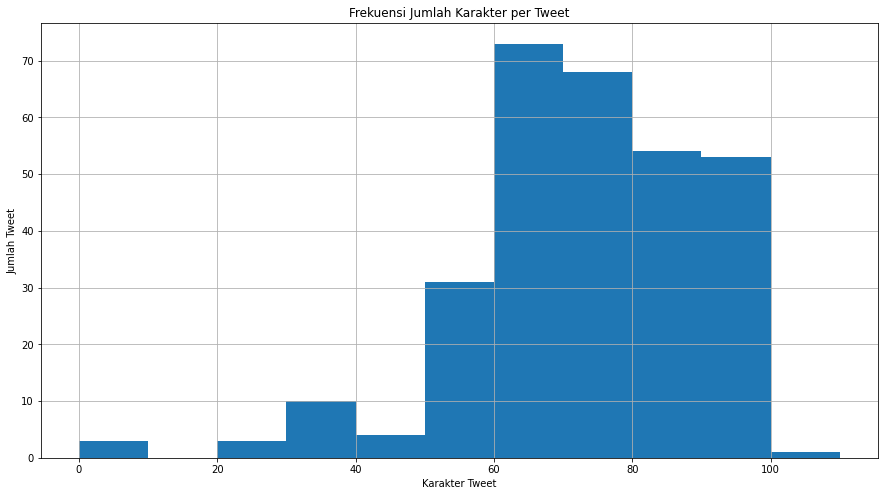

In [14]:
bin_range = np.arange(0, 120, 10)
plt.figure(figsize=(15,8))
# df['clean_tweet'].str.len().hist(bins = bin_range, histtype='stepfilled')
plt.hist(df['clean_tweet'].str.len(), bins=bin_range)

plt.xlabel('Karakter Tweet')
plt.ylabel('Jumlah Tweet')
plt.title('Frekuensi Jumlah Karakter per Tweet')

plt.grid(True)

plt.show()

In [15]:
np.mean(df['clean_tweet'].str.len())

73.43

In the graph of the frequency of the number of characters per data, the most tweets are 60-70 characters with an average published tweet of 73.43 characters.

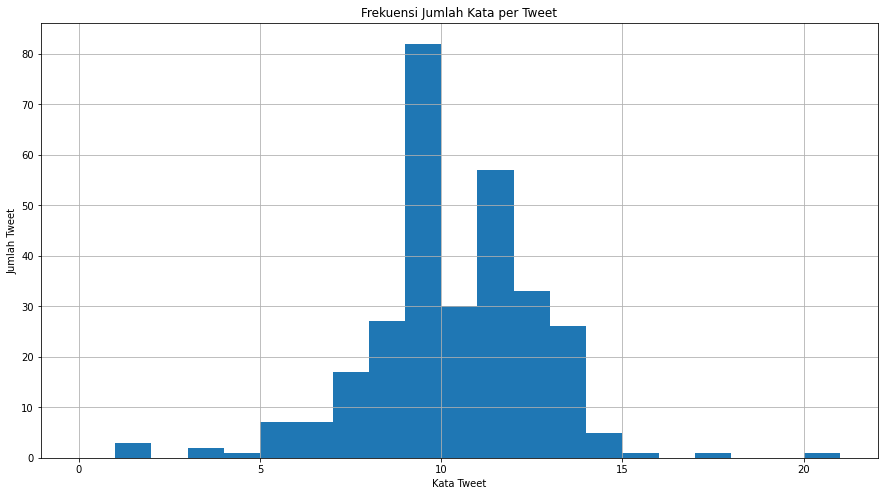

In [16]:
plt.figure(figsize=(15,8))
bin_range = np.arange(0, 22)

plt.hist(df['clean_tweet'].str.split().map(lambda x: len(x)), bins=bin_range)

plt.xlabel('Kata Tweet')
plt.ylabel('Jumlah Tweet')
plt.title('Frekuensi Jumlah Kata per Tweet')

plt.grid(True)

plt.show()

In [17]:
np.mean(df['clean_tweet'].str.split().map(lambda x: len(x)))

9.82

In the Frequency Number of Words per Data graph, the distribution of the most Tweet Words is at 9 Words per Tweet, with the number of Tweets being more than 11 Words per Tweet on average below 40 Tweets. Average Words per Tweet published is 9.82 Words per Tweet.

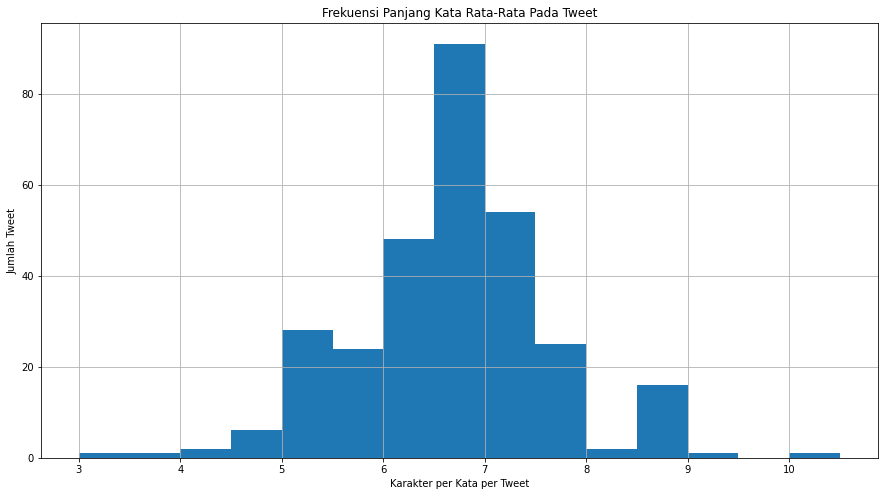

In [18]:
plt.figure(figsize=(15,8))
plt.hist(df['clean_tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)), bins=np.arange(3, 11, 0.5))

plt.xlabel('Karakter per Kata per Tweet')
plt.ylabel('Jumlah Tweet')
plt.title('Frekuensi Panjang Kata Rata-Rata Pada Tweet')

plt.grid(True)

plt.show()

In [19]:
np.mean(df['clean_tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)))

6.619813015960075

The most distribution is at 6.5 Characters per Word per Tweet, with a Tweet Count of more than 80 Tweets. And an average of 6.6198 Characters per Word per Tweet.

It can be concluded that in the previous frequency distribution analysis, the average tweet was at 9 words per Tweet, with each word per Tweet 6.5 characters, and a total of 60-70 characters. It can be said that people are enthusiastic about expressing their opinions.

In [20]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in df['clean_tweet'] for word in tweet]
fqdist = FreqDist(tweets)
print(fqdist)

<FreqDist with 724 samples and 2946 outcomes>


In [21]:
most_word_common = fqdist.most_common(20)
print(most_word_common)

[('nft', 206), ('indonesia', 200), ('ghozali', 150), ('ghozalu', 106), ('adrian', 103), ('zakhary', 83), ('keunikan', 50), ('bukti', 46), ('masyarakat', 44), ('inisiator', 44), ('kdri', 44), ('potensi', 42), ('menj', 38), ('apresiasi', 36), ('berhasil', 26), ('digital', 26), ('ya', 26), ('orang', 24), ('foto', 24), ('metaverse', 22)]


These are the most used words in the tweet

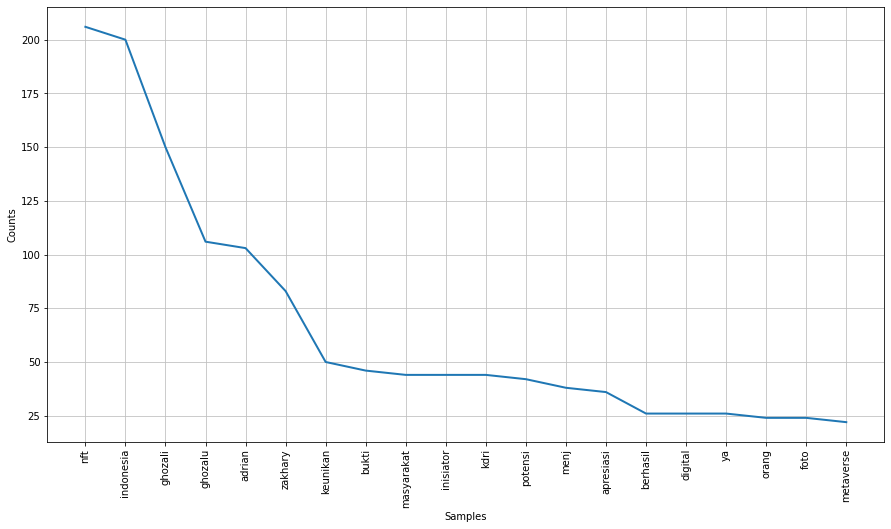

In [22]:
plt.figure(figsize=(15,8))
fqdist.plot(20, cumulative=False)
plt.show()

NFT became the top search word, followed by Indonesia and ghozali ghozalu and adrian zakhary. I have done research that, Ghozali Ghozalu or Ghozali Everyday is viral in social media because the NFT that he sells is a selfie of himself. Therefore, many media are up about Ghozali Ghozalu and Mr. Adrian Zakhary as young Indonesian digital figures giving their responses about the number of NFTs in Indonesia.

## Data Processing

In [23]:
pos_list= open("./kata_positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./kata_negatif.txt","r")
neg_kata = neg_list.readlines()

I use positive and negative words to help find the right sentiment for each tweet

In [24]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: clear_stopwords(x))
df

,tweet,clean_tweet
0,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...
1,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil nft dikena...
2,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...
3,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...
4,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil nft dikena...
...,...,...
295,Ghozali Ghozalu sudah menjual sebanyak 933 NFT...,ghozali ghozalu menjual nft harga eth rp ribu ...
296,Inisiator Kedaulatan Digital Republik Indonesi...,inisiator kedaulatan digital republik indonesi...
297,Cerita Adrian dibalik kesuksesan Ghozali menda...,cerita adrian dibalik kesuksesan ghozali uang ...
298,fenomena NFT di Indonesia pun mulai meningkat ...,fenomena nft indonesia meningkat masyarakat pe...


In [25]:
items=[]
for tweet in df['clean_tweet']:
    items.append(' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()))


In [26]:
hasil = []
list_anti = ['tidak','lawan','anti', 'belum', 'belom', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'sulit', 'tak', 'sblm']
for item in items:
    print(item.strip())
    tweets = item.strip().split() #tokenization
    
    count_p = 0 #nilai positif
    count_n = 0 #nilai negatif
    
    for tweet in tweets:
        for kata_pos in pos_kata:
            if kata_pos.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_pos, ['negatif'])
                    count_n += 1
                else:
                    print(kata_pos, ['positif'])
                    count_p += 1
        for kata_neg in neg_kata:
            if kata_neg.strip().lower() == tweet.lower():
                if items[items.index(item)-1] in list_anti:
                    print(items[items.index(item)-1], kata_neg, ['positif'])
                    count_p += 1
                else:
                    print(kata_neg, ['negatif'])
                    count_n += 1
    
    print ("positif: "+str(count_p))
    print ("negatif: "+str(count_n))
    
    if (count_p - count_n) > 0:
        hasil.append('Positif')
    elif (count_p - count_n) == 0:
        hasil.append('Netral')
    else :
        hasil.append('Negatif')

ghozali berhasil nft dikenal masyarakat luas indonesia orang penasaran memburu koleksinya
berhasil
 ['positif']
positif: 1
negatif: 0
lordghozalikuyouid ghozali berhasil nft dikenal masyarakat luas indonesia orang penasaran memburu
berhasil
 ['positif']
positif: 1
negatif: 0
ghozali berhasil nft dikenal masyarakat luas indonesia orang penasaran memburu koleksinya
berhasil
 ['positif']
positif: 1
negatif: 0
ghozali berhasil nft dikenal masyarakat luas indonesia orang penasaran memburu koleksinya
berhasil
 ['positif']
positif: 1
negatif: 0
lordghozalikuyouid ghozali berhasil nft dikenal masyarakat luas indonesia orang penasaran memburu
berhasil
 ['positif']
positif: 1
negatif: 0
lordghozalikuyouid ghozali berhasil nft dikenal masyarakat luas indonesia orang penasaran memburu
berhasil
 ['positif']
positif: 1
negatif: 0
ghozali berhasil nft dikenal masyarakat luas indonesia orang penasaran amp memburu koleksinya tid
berhasil
 ['positif']
positif: 1
negatif: 0
lordghozalikuyouid ghozali ber

In this process, I look for positive words and negative words in each word. By separating the words first and applying lowercase letters. Then compare them with the words in the positive words and negative words that have been made with the anti list.

Then count the positive and negative words in the sentence, if the Positive Total is greater than the Negative Total, then the result of the sentiment is Positive. If Total Positive is equal to Total Negative then the sentiment result is Neutral. And if Total Positive is less than Total Negative then the sentiment result is Negative.

In [27]:
df['sentiment'] = hasil
df

,tweet,clean_tweet,sentiment
0,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...,Positif
1,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil nft dikena...,Positif
2,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...,Positif
3,Ghozali berhasil membuat NFT dikenal masyaraka...,ghozali berhasil nft dikenal masyarakat luas i...,Positif
4,LordGhozaliKuyouID Ghozali berhasil membuat NF...,lordghozalikuyouid ghozali berhasil nft dikena...,Positif
...,...,...,...
295,Ghozali Ghozalu sudah menjual sebanyak 933 NFT...,ghozali ghozalu menjual nft harga eth rp ribu ...,Netral
296,Inisiator Kedaulatan Digital Republik Indonesi...,inisiator kedaulatan digital republik indonesi...,Positif
297,Cerita Adrian dibalik kesuksesan Ghozali menda...,cerita adrian dibalik kesuksesan ghozali uang ...,Positif
298,fenomena NFT di Indonesia pun mulai meningkat ...,fenomena nft indonesia meningkat masyarakat pe...,Positif


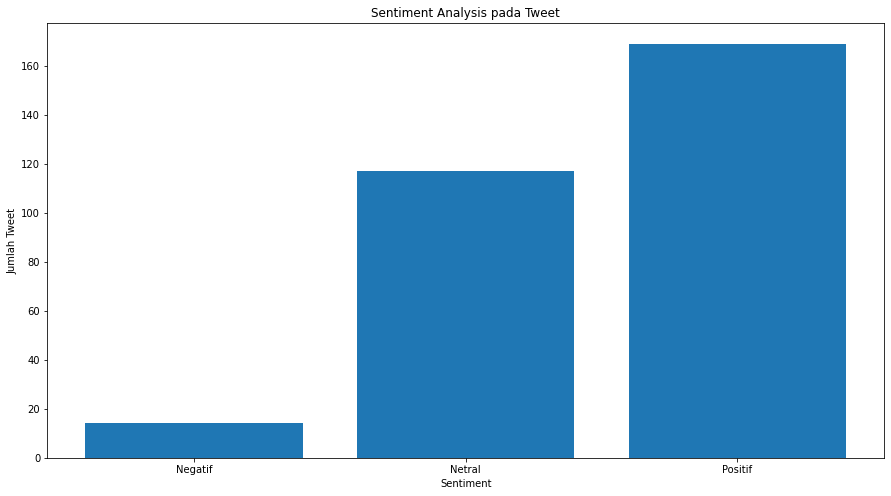

In [28]:
labels, counts = np.unique(hasil, return_counts=True)

plt.figure(figsize=(15,8))

plt.bar(labels, counts, align='center')

plt.gca().set_xticks(labels)

plt.xlabel('Sentiment')
plt.ylabel('Jumlah Tweet')
plt.title('Sentiment Analysis pada Tweet')

plt.show()

After doing sentiment analysis, it can be seen in Tweets with the topic 'NFT in Indonesia' statements that appear to be positive, with the majority of about 160 Tweets being positive tweets, and around 120 neutral Tweets (the number of positive and negative words being the same), and only about 20 Tweets. whose statement is negative.

Based on this, it can be concluded that the Sentiment Analysis conducted found that Tweets with the topic 'NFT in Indonesia' received a positive trend in the eyes of the Indonesian people. But it can be seen that everything has its pros and cons. When Ghozali went viral everyday with his NFT selfie, after I did some research, many Indonesians uploaded their E-KTPs and traded them on OpenSea. This is a negative action shown as Indonesian people.

In [29]:
data_berita = [berita.split() for berita in df["clean_tweet"]]
data_berita

[['ghozali',
  'berhasil',
  'nft',
  'dikenal',
  'masyarakat',
  'luas',
  'indonesia',
  'orang',
  'penasaran',
  'memburu',
  'koleksinya'],
 ['lordghozalikuyouid',
  'ghozali',
  'berhasil',
  'nft',
  'dikenal',
  'masyarakat',
  'luas',
  'indonesia',
  'orang',
  'penasaran',
  'memburu'],
 ['ghozali',
  'berhasil',
  'nft',
  'dikenal',
  'masyarakat',
  'luas',
  'indonesia',
  'orang',
  'penasaran',
  'memburu',
  'koleksinya'],
 ['ghozali',
  'berhasil',
  'nft',
  'dikenal',
  'masyarakat',
  'luas',
  'indonesia',
  'orang',
  'penasaran',
  'memburu',
  'koleksinya'],
 ['lordghozalikuyouid',
  'ghozali',
  'berhasil',
  'nft',
  'dikenal',
  'masyarakat',
  'luas',
  'indonesia',
  'orang',
  'penasaran',
  'memburu'],
 ['lordghozalikuyouid',
  'ghozali',
  'berhasil',
  'nft',
  'dikenal',
  'masyarakat',
  'luas',
  'indonesia',
  'orang',
  'penasaran',
  'memburu'],
 ['ghozali',
  'berhasil',
  'nft',
  'dikenal',
  'masyarakat',
  'luas',
  'indonesia',
  'orang',

Here I will do modeling on each tweet, by looking for the best coherence

In [30]:
dictionary = corpora.Dictionary(data_berita)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_berita]
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

In [31]:
pprint(ldamodel.print_topics())

[(0,
  '0.111*"nft" + 0.043*"indonesia" + 0.041*"foto" + 0.037*"fenomena" + '
  '0.021*"karya" + 0.018*"ghozali" + 0.016*"langit" + 0.016*"mengapresiasi" + '
  '0.016*"miliknya" + 0.014*"opensea"'),
 (1,
  '0.089*"nft" + 0.052*"indonesia" + 0.024*"kripto" + 0.020*"uang" + '
  '0.020*"kali" + 0.018*"sukses" + 0.017*"minat" + 0.017*"mata" + '
  '0.017*"investasi" + 0.016*"nya"'),
 (2,
  '0.055*"nft" + 0.046*"indonesia" + 0.039*"komunitas" + 0.017*"kominfo" + '
  '0.016*"d" + 0.012*"aset" + 0.011*"produk" + 0.011*"trend" + '
  '0.009*"memproduksi" + 0.009*"terlepas"'),
 (3,
  '0.076*"nft" + 0.067*"masyarakat" + 0.056*"indonesia" + 0.054*"ghozali" + '
  '0.039*"berhasil" + 0.026*"adrian" + 0.026*"memperkenalkan" + '
  '0.026*"mengedukasi" + 0.023*"lordghozalikuyouid" + 0.018*"orang"'),
 (4,
  '0.093*"ghozalu" + 0.091*"ghozali" + 0.075*"adrian" + 0.071*"zakhary" + '
  '0.064*"indonesia" + 0.043*"keunikan" + 0.039*"kdri" + 0.039*"inisiator" + '
  '0.039*"bukti" + 0.034*"potensi"')]


In [32]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_berita, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39386795359166726


The temporary coherence value is obtained with a value of: 0.39387

In [33]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_berita, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [34]:
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

This is a process where the tuning is to find the corpus with 75% and 100% of the corpus in order to eliminate those that are not at the specified corpus value. Hyper Tuning aims to improve the coherence value, then look for the best values.

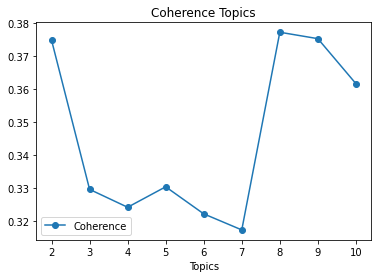

In [35]:
df_tuning_result = pd.read_csv('lda_tuning_results.csv')
df_plot = df_tuning_result[(df_tuning_result.Alpha == "0.01") & (df_tuning_result.Beta == "0.31") & (df_tuning_result.Validation_Set == "100% Corpus")].copy()

df_plot.plot(x='Topics', y = "Coherence", kind="line", marker='o')
plt.title('Coherence Topics')

plt.show()

On the Coherence Topics chart, the best Topics are shown in 8 topics, with very little difference with only 2 topics. For that I will use 8 topics to find the best coherence value, and 100% corpus.

In [36]:
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 8) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
456,100% Corpus,8,0.31,0.31,0.417837
474,100% Corpus,8,symmetric,symmetric,0.417496
458,100% Corpus,8,0.31,0.9099999999999999,0.417050
457,100% Corpus,8,0.31,0.61,0.414945
459,100% Corpus,8,0.31,symmetric,0.414541
473,100% Corpus,8,symmetric,0.9099999999999999,0.412092
472,100% Corpus,8,symmetric,0.61,0.410771
460,100% Corpus,8,0.61,0.01,0.408427
455,100% Corpus,8,0.31,0.01,0.408344
466,100% Corpus,8,0.9099999999999999,0.31,0.406881


After sorting topic 8, the alpha and beta values are 0.31, with a coherence value of 0.417837. This is already better than the coherence value before Hyper Tuning, which was 0.39387

In [37]:
lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.31)

pprint(lda_model.print_topics())

[(0,
  '0.059*"nft" + 0.050*"indonesia" + 0.027*"masyarakat" + 0.027*"uang" + '
  '0.025*"kripto" + 0.023*"minat" + 0.023*"mata" + 0.023*"investasi" + '
  '0.023*"ghozalilivekuyouid" + 0.021*"keren"'),
 (1,
  '0.068*"nft" + 0.036*"indonesia" + 0.020*"komunitas" + 0.020*"nya" + '
  '0.018*"kali" + 0.018*"menyebut" + 0.018*"dipromosikan" + 0.013*"orang" + '
  '0.010*"semarang" + 0.010*"mahasiswa"'),
 (2,
  '0.047*"nft" + 0.043*"indonesia" + 0.014*"anang" + 0.011*"game" + '
  '0.009*"parcamods" + 0.009*"dunia" + 0.007*"d" + 0.007*"metaverse" + '
  '0.007*"hermasnyah" + 0.007*"tradisional"'),
 (3,
  '0.058*"ghozali" + 0.057*"nft" + 0.052*"indonesia" + 0.047*"adrian" + '
  '0.033*"zakhary" + 0.032*"ghozalu" + 0.032*"apresiasi" + 0.032*"kdri" + '
  '0.032*"inisiator" + 0.025*"masyarakat"'),
 (4,
  '0.020*"indonesia" + 0.012*"foto" + 0.010*"opensea" + 0.007*"teman" + '
  '0.007*"realitas" + 0.007*"calon" + 0.007*"miliaran" + 0.007*"aspek" + '
  '0.007*"nih" + 0.007*"nftd"'),
 (5,
  '0.030*"in

With topic number 8, we get 8 different topics with the best coherence value. The best topics are:

1. Masyarakat Indonesia minat investasi pada uang kripto karena NFT
2. Anang Hermansyah mulai merambah ke NFT, dan dunia metaverse
3. Adrian Zakhary insiator KDRI apresiasi ghozali ghozalu karena NFT
4. Indonesia memantau perkembangan minat pada NFT (Non Fungible Token)

## Conclusion

After doing an analysis of NFT in Indonesia via Twitter, by accessing the Twitter API. The result is a trend that has occurred in Indonesia regarding NFT since the viral Ghozali Everyday has garnered positive public enthusiasm. With several main topics, namely:

1. Masyarakat Indonesia minat investasi pada uang kripto karena NFT
2. Anang Hermansyah mulai merambah ke NFT, dan dunia metaverse
3. Adrian Zakhary insiator KDRI apresiasi ghozali ghozalu karena NFT
4. Indonesia memantau perkembangan minat pada NFT (Non Fungible Token)

The Indonesian people have started to look to the digital realm, namely NFT and Metaverse as well as Cryptocurrency which is a digital investment option.